
[MAIN QUEST 03] 폐렴아 기다려라!
채점 기준 (총 5점)

프로젝트 제출 : 1점
루브릭 : 4점

의료영상을 처리하는 CNN 기반 베이스 모델이 잘 구현되었다 -1점

데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교 - 1점

모델 구조 변경을 통해 베이스 모델과의 성능 비교 - 1점

ResNet-18 모델을 구현하고 학습 성공 - 1점



※ 보고서 양식 (개요, 목차, 주석 및 의견, summary, 회고, reference 등)이 포함되어 있지 않을 경우 감점 1점



# 1.베이스 모델 실행하기

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:00<00:00, 41.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수 - path는 이미 kagglehub.dataset_download()로 받은 경로입니다
base_path = os.path.join(path, 'chest_xray')
TRAIN_PATH = os.path.join(base_path, 'train/*/*')
VAL_PATH = os.path.join(base_path, 'val/*/*')
TEST_PATH = os.path.join(base_path, 'test/*/*')

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print("Train path:", TRAIN_PATH)
print("Val path:", VAL_PATH)
print("Test path:", TEST_PATH)

Train path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/*/*
Val path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val/*/*
Test path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/*/*


In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)

print("훈련 데이터 개수:", len(train_filenames))
print("검증 데이터 개수:", len(val_filenames))
print("테스트 데이터 개수:", len(test_filenames))

훈련 데이터 개수: 5216
검증 데이터 개수: 16
테스트 데이터 개수: 624


In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0358-0001.jpeg
Pneumonia image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person162_virus_319.jpeg


In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 5216
Validating images count: 16


In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# # 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
# def process_path(file_path):
#     label = get_label(file_path) # 라벨 검출
#     img = tf.io.read_file(file_path) # 이미지 읽기
#     img = decode_img(img) # 이미지를 알맞은 형식으로 수정
#     return img, label

# 수정된 process_path 함수
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출 (bool 타입)
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞은 형식으로 수정
    label = tf.cast(label, tf.int32)  # 라벨을 int32로 변환
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

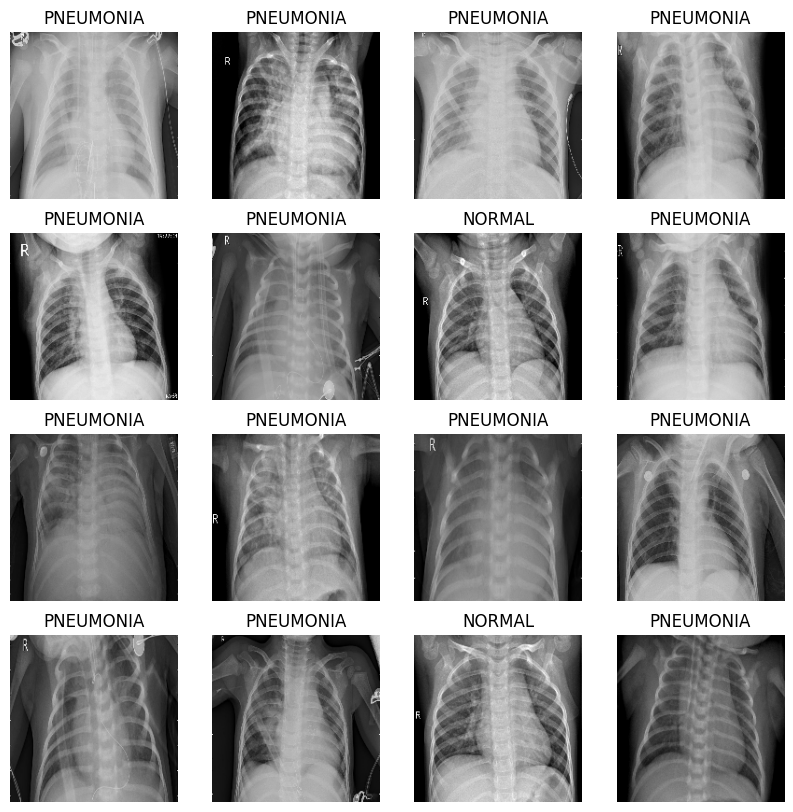

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
# LMS에서 계산된 값들을 직접 사용
COUNT_NORMAL = 1341  # 정상 이미지 수
COUNT_PNEUMONIA = 3875  # 폐렴 이미지 수
TRAIN_IMG_COUNT = 5216  # 전체 훈련 이미지 수

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 120s 270ms/step - accuracy: 0.7303 - loss: 0.5271 - precision: 0.9199 - recall: 0.6903 - val_accuracy: 0.7356 - val_loss: 0.7996 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 75s 230ms/step - accuracy: 0.9083 - loss: 0.2331 - precision: 0.9714 - recall: 0.9034 - val_accuracy: 0.7385 - val_loss: 1.2353 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 73s 225ms/step - accuracy: 0.9322 - loss: 0.1879 - precision: 0.9785 - recall: 0.9284 - val_accuracy: 0.9644 - val_loss: 0.1059 - val_precision: 0.9814 - val_recall: 0.9697
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 76s 232ms/step - accuracy: 0.9344 - loss: 0.1882 - precision: 0.9813 - recall: 0.9294 - val_accuracy: 0.9404 - val_loss: 0.1485 - val_precision: 0.9958 - val_recall: 0.9231
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 70s 216ms/step - accuracy: 0.9391 - loss: 0.1588 - precision: 0.9871 - recall: 0.9311 - val_accuracy: 0.960

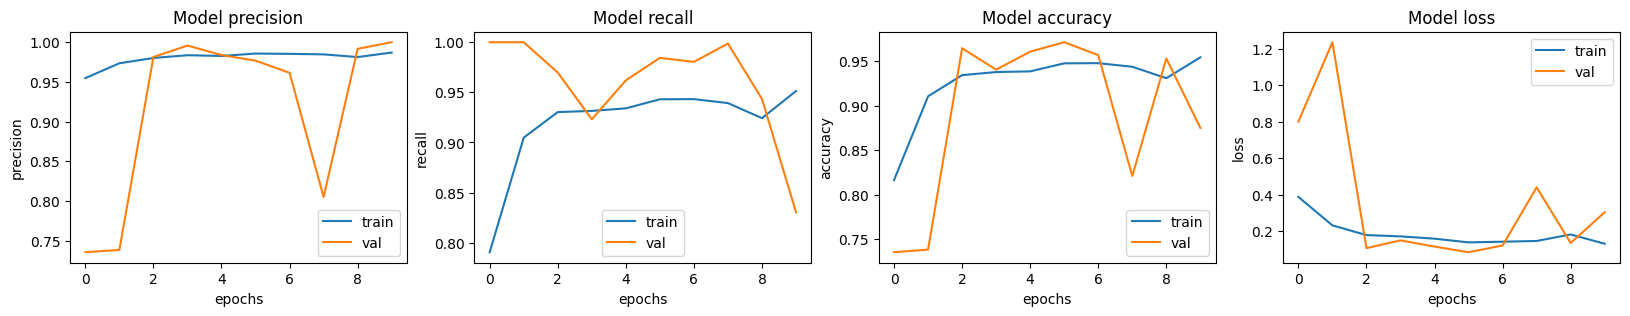

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.8715 - loss: 0.3555 - precision: 0.8900 - recall: 0.9130
Loss: 0.37956365942955017,
Accuracy: 0.8637820482254028,
Precision: 0.8746928572654724,
Recall: 0.9128205180168152


# 2.베이스 모델 구축후 데이터 증강 사용해보기

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = test_ds.batch(BATCH_SIZE)


In [ ]:
with tf.device('/GPU:0'):  # GPU를 사용할 경우
    history = model.fit(
        train_ds,  # 학습 데이터셋
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,  # 한 epoch 당 스텝 수
        epochs=EPOCHS,  # 총 학습 epoch 수
        validation_data=val_ds,  # 검증 데이터셋 (증강 적용됨)
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,  # 한 epoch 당 검증 스텝 수
        class_weight=class_weight,  # 클래스 가중치 (필요 시)
    )

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 97s 260ms/step - accuracy: 0.9378 - loss: 0.1739 - precision: 0.9790 - recall: 0.9358 - val_accuracy: 0.8962 - val_loss: 0.2585 - val_precision: 0.9985 - val_recall: 0.8598
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 79s 243ms/step - accuracy: 0.9399 - loss: 0.1454 - precision: 0.9837 - recall: 0.9340 - val_accuracy: 0.9279 - val_loss: 0.1621 - val_precision: 0.9971 - val_recall: 0.9047
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 75s 230ms/step - accuracy: 0.9496 - loss: 0.1337 - precision: 0.9863 - recall: 0.9452 - val_accuracy: 0.9683 - val_loss: 0.0830 - val_precision: 0.9919 - val_recall: 0.9646
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 85s 263ms/step - accuracy: 0.9493 - loss: 0.1169 - precision: 0.9904 - recall: 0.9411 - val_accuracy: 0.9500 - val_loss: 0.1393 - val_precision: 0.9407 - val_recall: 0.9948
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 78s 240ms/step - accuracy: 0.9588 - loss: 0.1133 - precision: 0.9917 - recall: 0.9528 - val_accuracy: 0.8519

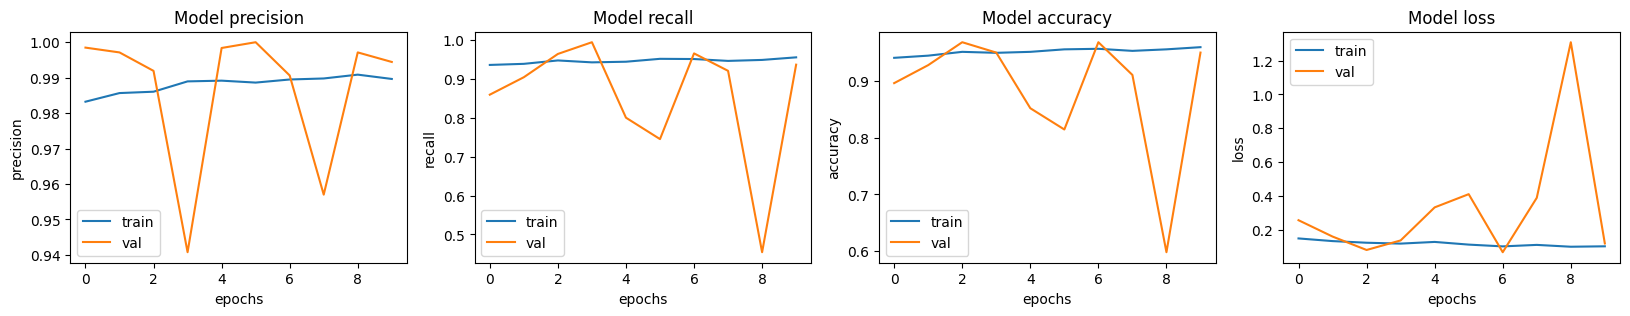

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.8085 - loss: 0.7305 - precision: 0.7915 - recall: 0.9479
Loss: 0.8438822627067566,
Accuracy: 0.8028846383094788,
Precision: 0.7834395170211792,
Recall: 0.9461538195610046


In [ ]:
# 학습 데이터셋: 증강 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = prepare_for_training(train_ds)  # prepare_for_training에서 augment 함수 적용

# 검증 데이터셋: 증강 제거
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# 모델 학습
with tf.device('/GPU:0'):  # GPU를 사용할 경우
    history = model.fit(
        train_ds,  # 학습 데이터셋 (증강 적용됨)
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,  # 한 epoch 당 스텝 수
        epochs=EPOCHS,  # 총 학습 epoch 수
        validation_data=val_ds,  # 검증 데이터셋 (증강 제거됨)
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,  # 한 epoch 당 검증 스텝 수
    )

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 94s 221ms/step - accuracy: 0.9665 - loss: 0.0907 - precision: 0.9823 - recall: 0.9724 - val_accuracy: 0.9683 - val_loss: 0.0698 - val_precision: 0.9741 - val_recall: 0.9830
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 66s 204ms/step - accuracy: 0.9751 - loss: 0.0779 - precision: 0.9867 - recall: 0.9804 - val_accuracy: 1.0000 - val_loss: 0.0027 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 76s 235ms/step - accuracy: 0.9652 - loss: 0.0921 - precision: 0.9788 - recall: 0.9745 - val_accuracy: 0.9760 - val_loss: 0.0594 - val_precision: 0.9805 - val_recall: 0.9869
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 79s 242ms/step - accuracy: 0.9683 - loss: 0.0809 - precision: 0.9810 - recall: 0.9764 - val_accuracy: 1.0000 - val_loss: 0.0298 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 76s 234ms/step - accuracy: 0.9771 - loss: 0.0680 - precision: 0.9865 - recall: 0.9828 - val_accuracy: 0.9058

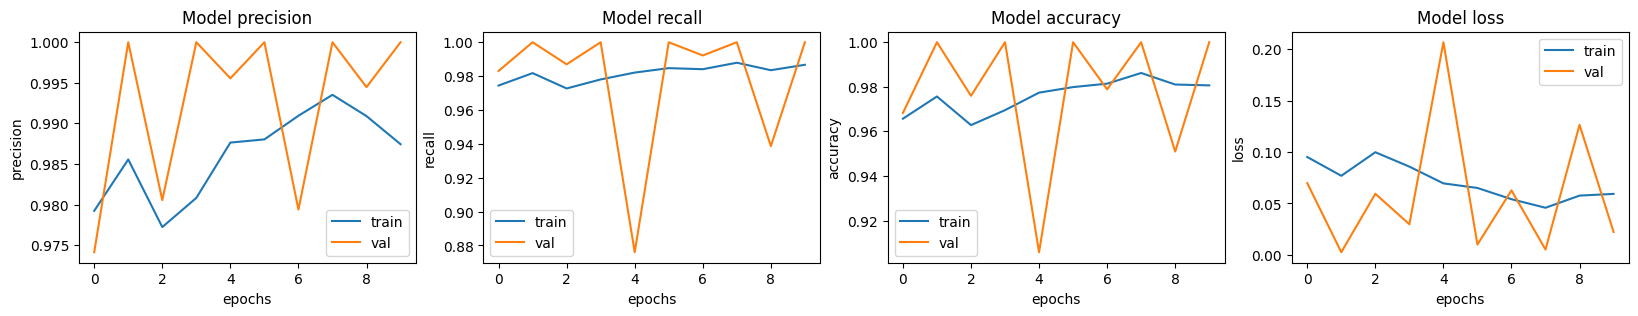

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.7988 - loss: 1.0115 - precision: 0.7582 - recall: 0.9904
Loss: 1.0308151245117188,
Accuracy: 0.8044871687889099,
Precision: 0.7637795209884644,
Recall: 0.9948717951774597


# 3 모델 구조 변경을 통해 베이스 모델과의 성능비교

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5 #배치 사이즈와 에포크 횟수 변경

In [ ]:
def inception_module(x, filters):
    f1, f3_reduce, f3, f5_reduce, f5, pool_proj = filters

    # 1x1 Conv
    conv1x1 = tf.keras.layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    # 1x1 Conv -> 3x3 Conv
    conv3x3_reduce = tf.keras.layers.Conv2D(f3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = tf.keras.layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    # 1x1 Conv -> 5x5 Conv
    conv5x5_reduce = tf.keras.layers.Conv2D(f5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv5x5 = tf.keras.layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    # 3x3 MaxPooling -> 1x1 Conv
    maxpool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = tf.keras.layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(maxpool)

    # Concatenate all branches
    return tf.keras.layers.Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_proj])


In [ ]:
def build_inception_model_with_aux(input_shape=(180, 180, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv Layers
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Inception Modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])  # Inception Module 1
    x = inception_module(x, [128, 128, 192, 32, 96, 64])  # Inception Module 2
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # First Auxiliary Classifier
    aux1 = tf.keras.layers.GlobalAveragePooling2D()(x)
    aux1 = tf.keras.layers.Dense(256, activation='relu')(aux1)
    aux1 = tf.keras.layers.Dropout(0.5)(aux1)
    aux1_output = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="aux1_output")(aux1)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])  # Inception Module 3
    x = inception_module(x, [160, 112, 224, 24, 64, 64])  # Inception Module 4
    x = inception_module(x, [128, 128, 256, 24, 64, 64])  # Inception Module 5
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Second Auxiliary Classifier
    aux2 = tf.keras.layers.GlobalAveragePooling2D()(x)
    aux2 = tf.keras.layers.Dense(256, activation='relu')(aux2)
    aux2 = tf.keras.layers.Dropout(0.5)(aux2)
    aux2_output = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="aux2_output")(aux2)

    # Final Inception Modules
    x = inception_module(x, [256, 160, 320, 32, 128, 128])  # Inception Module 6
    x = inception_module(x, [384, 192, 384, 48, 128, 128])  # Inception Module 7

    # Global Average Pooling + Dense Output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="main_output")(x)

    # Model with Auxiliary Classifiers
    model = tf.keras.Model(inputs=inputs, outputs=[outputs, aux1_output, aux2_output])
    return model


In [ ]:
model_with_aux = build_inception_model_with_aux(input_shape=(180, 180, 3), num_classes=1)

model_with_aux.compile(
    optimizer='adam',
    loss={'main_output': 'binary_crossentropy', 'aux1_output': 'binary_crossentropy', 'aux2_output': 'binary_crossentropy'},
    loss_weights={'main_output': 1.0, 'aux1_output': 0.3, 'aux2_output': 0.3},
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [ ]:
history = model_with_aux.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=5,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 514ms/step - loss: 0.1839 - main_output_accuracy: 0.7449 - val_loss: 0.1706 - val_main_output_accuracy: 0.7354
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 785ms/step - loss: 0.1660 - main_output_accuracy: 0.7427 - val_loss: 0.1162 - val_main_output_accuracy: 0.8696
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 505ms/step - loss: 0.1345 - main_output_accuracy: 0.7742 - val_loss: 0.1028 - val_main_output_accuracy: 0.8486
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 423ms/step - loss: 0.0845 - main_output_accuracy: 0.8823 - val_loss: 0.0622 - val_main_output_accuracy: 0.8261
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 498ms/step - loss: 0.0490 - main_output_accuracy: 0.9375 - val_loss: 0.0561 - val_main_output_accuracy: 0.9287


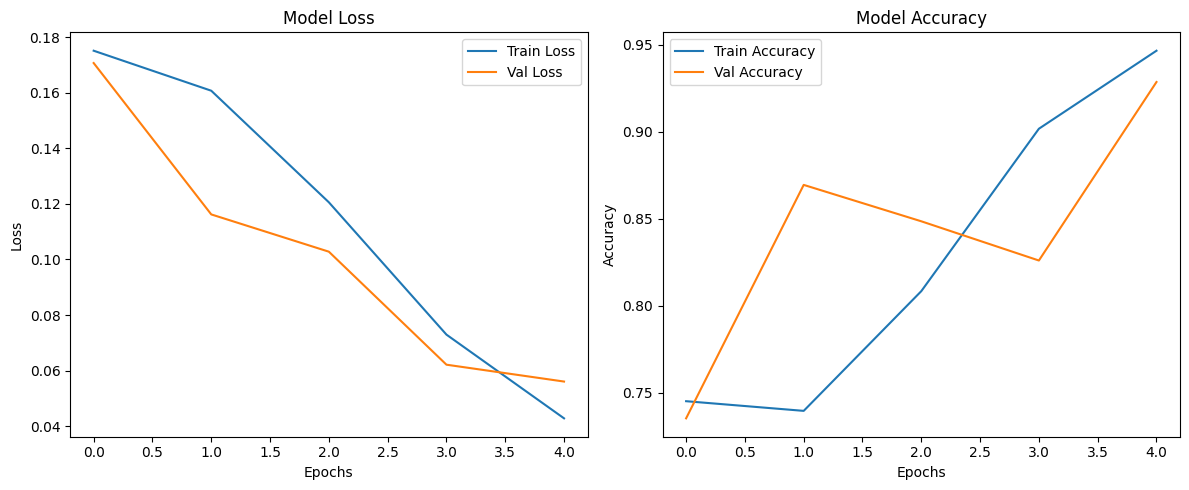

In [ ]:
# 시각화 - Loss와 Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()

# Loss 시각화
ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Accuracy 시각화
ax[1].plot(history.history['main_output_accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_main_output_accuracy'], label='Val Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
model_with_aux = build_inception_model_with_aux(input_shape=(180, 180, 3), num_classes=1)

model_with_aux.compile(
    optimizer='adam',
    loss={
        'main_output': 'binary_crossentropy',
        'aux1_output': 'binary_crossentropy',
        'aux2_output': 'binary_crossentropy'
    },
    loss_weights={
        'main_output': 1.0,
        'aux1_output': 0.3,
        'aux2_output': 0.3
    },
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


In [ ]:
history = model_with_aux.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=10,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 507ms/step - loss: 0.1831 - main_output_accuracy: 0.7232 - val_loss: 0.1501 - val_main_output_accuracy: 0.7354
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 804ms/step - loss: 0.1601 - main_output_accuracy: 0.7409 - val_loss: 0.1460 - val_main_output_accuracy: 0.7391
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 516ms/step - loss: 0.1450 - main_output_accuracy: 0.7516 - val_loss: 0.1208 - val_main_output_accuracy: 0.8076
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - loss: 0.1146 - main_output_accuracy: 0.8308 - val_loss: 0.0999 - val_main_output_accuracy: 0.9130
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - loss: 0.1061 - main_output_accuracy: 0.8328 - val_loss: 0.0883 - val_main_output_accuracy: 0.8916
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - loss: 0.0803 - main_output_accuracy: 0.8908 - val_loss: 0.0390 - val_main_output_accuracy: 0.9130
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 504ms/step - loss: 0.062

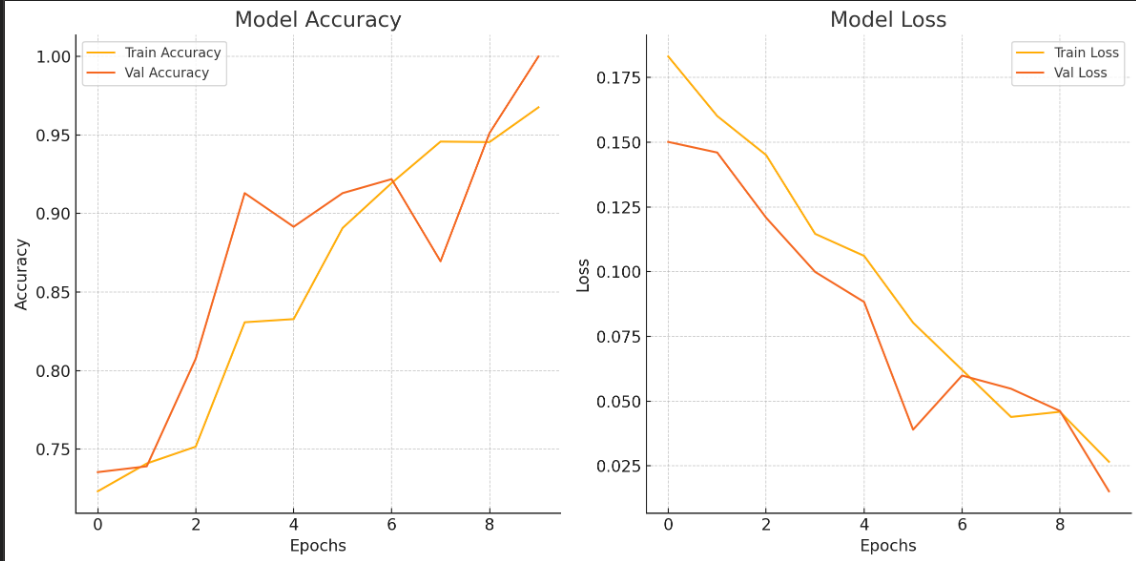

# 4.ResNet-18 모델을 구현하고  학습성공
<img src="https://www.researchgate.net/profile/Paolo-Napoletano/publication/322476121/figure/tbl1/AS:668726449946625@1536448218498/ResNet-18-Architecture.png" alt="ResNet-18 Architecture" width="400">

구조에서 알 수있는점
원바이원 컨브연산과 맥스 풀링으로 처음 사진을 압축시킴

이후 같은 채널수의 의 연산을 4번씩 하고 코드를 줄이고 스킵커넥션 구조를

추가하기위해 residual(잔차)_block 블록을 만들어 사용

마지막 global aberage pool 이후 mlp 구조에 학습시킴

In [ ]:
# Residual Block 구현
def residual_block(inputs, filters, stride=1):
    x = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # 스킵 커넥션 (Shortcut) -> 어떻게 추가할지 몰라서 찾아봄 사이즈 맞춰서 들어가는거랑 합산시 더하는거 기억하기
    shortcut = inputs
    if stride > 1 or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # 합산 (Skip Connection)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

In [ ]:
# ResNet-18
def build_resnet18(input_shape=(224, 224, 3), num_classes=1000):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    #  64x 2
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # 128 x 2
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    # 256x 2
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    # 512 x 2
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

resnet18 = build_resnet18(input_shape=(180, 180, 3), num_classes=1)
resnet18.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 90, 90, 64)     │          9,472 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 90, 90, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 45, 45, 64)     │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 45, 45, 64)     │         36,928 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 45, 45, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 45, 45, 64)     │         36,928 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 45, 45, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 45, 45, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 45, 45, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 45, 45, 64)     │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 45, 45, 64)     │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 45, 45, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 45, 45, 64)     │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 45, 45, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ re_lu[0][0]            │
├──────────────────────

 Total params: 11,191,425 (42.69 MB)

 Trainable params: 11,181,825 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
# 데이터셋 정의 (증강 제거된 데이터셋)
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
# 모델 컴파일
resnet18.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # 이진 분류 문제이므로 binary_crossentropy 사용
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# 모델 학습
with tf.device('/GPU:0'):  # GPU 사용
    history = resnet18.fit(
        train_ds,  # 학습 데이터셋
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,  # 한 epoch 당 step 수
        epochs=EPOCHS,  # 총 학습 epoch 수
        validation_data=val_ds,  # 검증 데이터셋
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,  # 한 epoch 당 검증 step 수
        class_weight=class_weight  # 클래스 가중치 적용
    )

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 101s 227ms/step - accuracy: 0.7428 - loss: 0.4131 - precision: 0.7428 - recall: 1.0000 - val_accuracy: 0.7365 - val_loss: 0.1520 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 66s 203ms/step - accuracy: 0.7428 - loss: 0.1486 - precision: 0.7428 - recall: 1.0000 - val_accuracy: 0.5714 - val_loss: 2.4643 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 69s 163ms/step - accuracy: 0.7428 - loss: 0.1216 - precision: 0.7428 - recall: 1.0000 - val_accuracy: 0.7365 - val_loss: 1.6137 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 73s 136ms/step - accuracy: 0.7428 - loss: 0.0973 - precision: 0.7428 - recall: 1.0000 - val_accuracy: 0.5714 - val_loss: 1.4043 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 93s 170ms/step - accuracy: 0.7428 - loss: 0.0696 - precision: 0.7428 - recall: 1.0000 - val_accuracy: 0.736

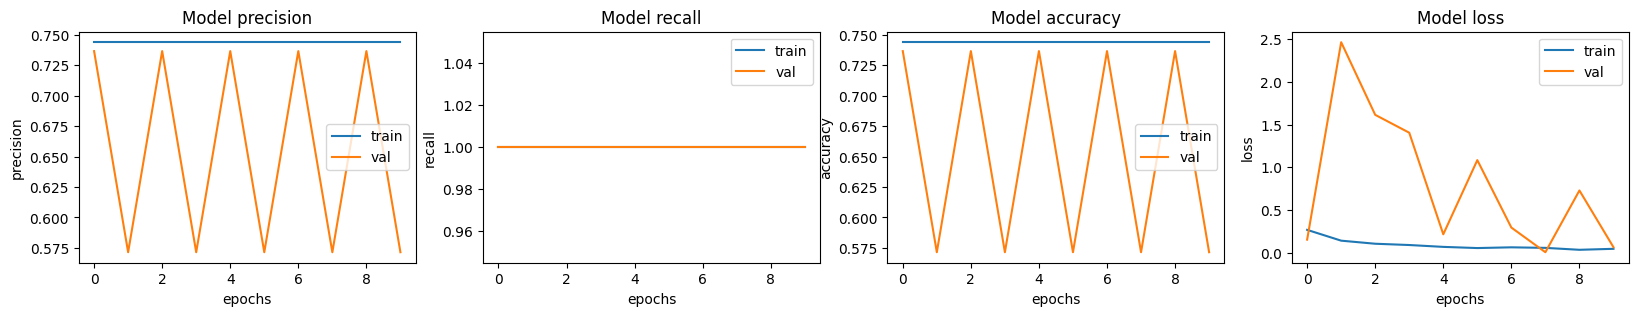

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')

    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7871 - loss: 1.1221 - precision: 0.7446 - recall: 0.9969
Loss: 1.0308152437210083,
Accuracy: 0.8044871687889099,
Precision: 0.7637795209884644,
Recall: 0.9948717951774597


In [ ]:
from collections import Counter

# 학습 데이터셋의 클래스 분포 확인
train_labels = [label.numpy() for _, label in train_ds.unbatch()]
print("Train class distribution:", Counter(train_labels))

# 검증 데이터셋의 클래스 분포 확인
val_labels = [label.numpy() for _, label in val_ds.unbatch()]
print("Validation class distribution:", Counter(val_labels))


Train class distribution: Counter({1: 3113, 0: 1072})
Validation class distribution: Counter({1: 770, 0: 277})


In [ ]:
# SGD Optimizer로 변경
resnet18.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # SGD 설정
    loss='binary_crossentropy',  # 이진 분류
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
with tf.device('/GPU:0'):  # GPU 사용
    history = resnet18.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight  # 클래스 가중치 적용
    )

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 209ms/step - accuracy: 0.7422 - loss: 4.0825e-04 - precision: 0.7422 - recall: 1.0000 - val_accuracy: 0.7441 - val_loss: 0.0472 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7375 - loss: 3.1541e-04 - precision: 0.7375 - recall: 1.0000 - val_accuracy: 0.7266 - val_loss: 0.0816 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 346ms/step - accuracy: 0.7422 - loss: 2.6844e-04 - precision: 0.7422 - recall: 1.0000 - val_accuracy: 0.7391 - val_loss: 0.2959 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.7375 - loss: 2.7072e-04 - precision: 0.7375 - recall: 1.0000 - val_accuracy: 0.7441 - val_loss: 0.0438 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - accuracy: 0.7422 - loss: 2.4452e-04 - precision: 0.7422 - recall: 1.0000 - val_a

In [ ]:
with tf.device('/GPU:0'):  # GPU 사용
    history = resnet18.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight  # 클래스 가중치 비적용
    )

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.7422 - loss: 4.3479e-04 - precision: 0.7422 - recall: 1.0000 - val_accuracy: 0.7441 - val_loss: 0.0517 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.7375 - loss: 3.9894e-04 - precision: 0.7375 - recall: 1.0000 - val_accuracy: 0.7266 - val_loss: 0.0790 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - accuracy: 0.7422 - loss: 3.4820e-04 - precision: 0.7422 - recall: 1.0000 - val_accuracy: 0.7391 - val_loss: 0.2655 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 171ms/step - accuracy: 0.7375 - loss: 3.3461e-04 - precision: 0.7375 - recall: 1.0000 - val_accuracy: 0.7441 - val_loss: 0.0460 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 219ms/step - accuracy: 0.7422 - loss: 3.0785e-04 - precision: 0.7422 - recall: 1.0000 - val_a

In [ ]:
# 데이터셋의 레이블 확인
for image, label in train_ds.take(10):
    print(label.numpy())  # 레이블이 정상적으로 분포되어 있는지 확인


[0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1]
[1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1]
[1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1]
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
[1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1]
[0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0]
[0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0]
[0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0]
[1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1]


In [ ]:
train_files = set([file.numpy().decode() for file in train_list_ds])
val_files = set([file.numpy().decode() for file in val_list_ds])

# 교집합 확인
duplicates = train_files.intersection(val_files)
print(f"Number of duplicate files: {len(duplicates)}")

Number of duplicate files: 0


In [ ]:
#드롭아웃 추가 버전 #sgd에서 adam 으로 다시 바꿈
def build_resnet18_with_dropout(input_shape=(180, 180, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Conv1
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks with Dropout
    x = residual_block(x, 64)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = residual_block(x, 512)

    # Global Average Pooling + Dense Output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Fully Connected Layer 이전 Dropout
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# 모델 생성
resnet18_dropout = build_resnet18_with_dropout(input_shape=(180, 180, 3), num_classes=1)


In [ ]:
# 클래스 가중치 없이 학습
resnet18_dropout.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

with tf.device('/GPU:0'):
    history_no_weights = resnet18_dropout.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 209ms/step - accuracy: 0.7985 - loss: 0.5512 - precision: 0.8637 - recall: 0.8611 - val_accuracy: 0.7441 - val_loss: 3.6222 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - accuracy: 0.9251 - loss: 0.2287 - precision: 0.9456 - recall: 0.9532 - val_accuracy: 0.7266 - val_loss: 3.3801 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 289ms/step - accuracy: 0.9246 - loss: 0.1872 - precision: 0.9506 - recall: 0.9478 - val_accuracy: 0.7391 - val_loss: 2.4867 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.9366 - loss: 0.1706 - precision: 0.9525 - recall: 0.9619 - val_accuracy: 0.6523 - val_loss: 0.9260 - val_precision: 0.9356 - val_recall: 0.5722
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 227ms/step - accuracy: 0.9550 - loss: 0.1178 - precision: 0.9718 - recall: 0.9676 - val_accuracy: 0.7969 - va

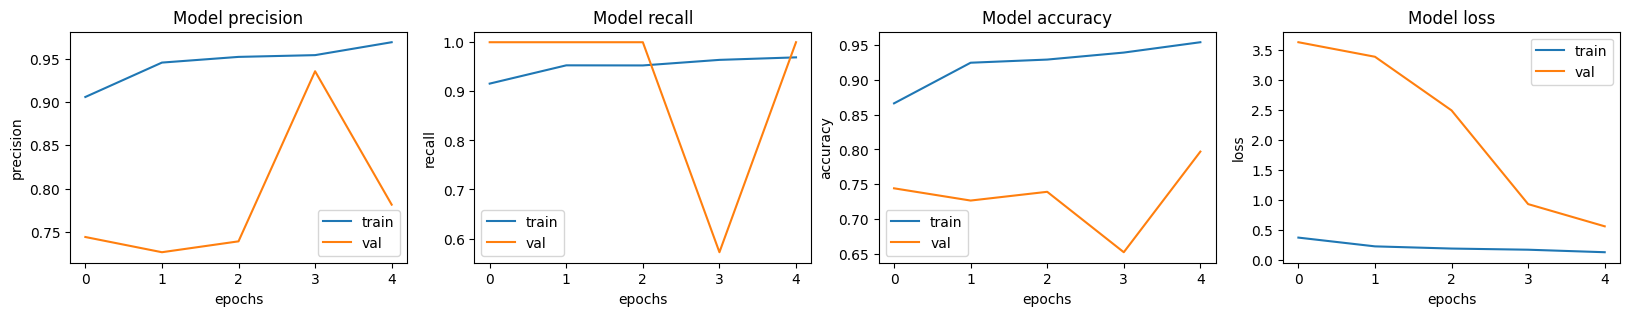

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_weights.history[met])                    # history_with_weights -> history_no_weights
    ax[i].plot(history_no_weights.history['val_' + met])          # history_with_weights -> history_no_weights
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# 클래스 가중치 적용 학습
resnet18_dropout.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

with tf.device('/GPU:0'):
    history_with_weights = resnet18_dropout.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight  # 기존 클래스 가중치
    )

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 213ms/step - accuracy: 0.9217 - loss: 0.2386 - precision: 0.9660 - recall: 0.9275 - val_accuracy: 0.2617 - val_loss: 5.0709 - val_precision: 1.0000 - val_recall: 0.0079
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 204ms/step - accuracy: 0.9367 - loss: 0.1770 - precision: 0.9740 - recall: 0.9392 - val_accuracy: 0.8398 - val_loss: 0.3231 - val_precision: 0.8251 - val_recall: 0.9892
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 262ms/step - accuracy: 0.9592 - loss: 0.1238 - precision: 0.9896 - recall: 0.9552 - val_accuracy: 0.7391 - val_loss: 1.5049 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.9450 - loss: 0.1266 - precision: 0.9838 - recall: 0.9409 - val_accuracy: 0.7461 - val_loss: 0.6526 - val_precision: 0.7475 - val_recall: 0.9948
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 218ms/step - accuracy: 0.9516 - loss: 0.1298 - precision: 0.9837 - recall: 0.9507 - val_accuracy: 0.9570 - va

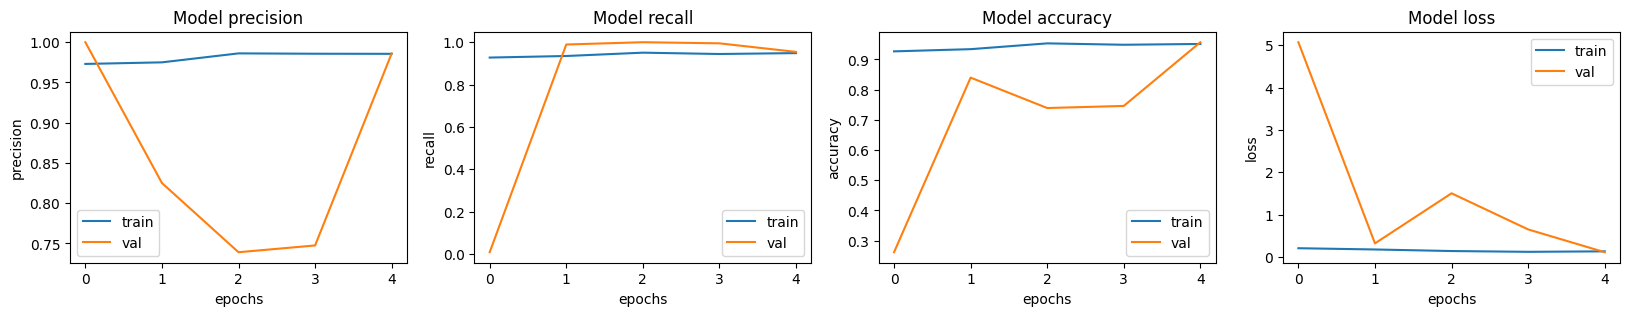

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_with_weights.history[met])                    # history -> history_with_weights
    ax[i].plot(history_with_weights.history['val_' + met])          # history -> history_with_weights
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# 현재 나온것중 그나마 좋아보이는거 반복횟수 늘려보기
with tf.device('/GPU:0'):
    history_with_weights = resnet18_dropout.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=10,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight  # 기존 클래스 가중치
    )

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 443ms/step - accuracy: 0.9562 - loss: 0.1021 - precision: 0.9891 - recall: 0.9523 - val_accuracy: 0.7705 - val_loss: 0.9209 - val_precision: 0.7621 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 375ms/step - accuracy: 0.9638 - loss: 0.0968 - precision: 0.9888 - recall: 0.9619 - val_accuracy: 0.7391 - val_loss: 1.8920 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 443ms/step - accuracy: 0.9713 - loss: 0.0765 - precision: 0.9930 - recall: 0.9680 - val_accuracy: 0.9365 - val_loss: 0.1623 - val_precision: 0.9971 - val_recall: 0.9163
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 424ms/step - accuracy: 0.9715 - loss: 0.0682 - precision: 0.9919 - recall: 0.9693 - val_accuracy: 0.9565 - val_loss: 0.1243 - val_precision: 1.0000 - val_recall: 0.9412
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 430ms/step - accuracy: 0.9784 - loss: 0.0622 - precision: 0.9946 - recall: 0.9764 - val_accuracy: 0.9736

In [ ]:
#학습데이터에만 증강 시키고 드롭아웃 적용해 보기
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 학습 데이터에만 증강 적용
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=AUTOTUNE
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# 학습 데이터: 증강 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = prepare_for_training(train_ds)

# 검증 데이터: 증강 미적용
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# 테스트 데이터: 증강 미적용
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


In [ ]:
# 모델 학습
with tf.device('/GPU:0'):  # GPU 사용
    history = resnet18.fit(
        train_ds,  # 학습 데이터셋 (증강 적용)
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,  # 검증 데이터셋 (증강 미적용)
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 511ms/step - accuracy: 0.7412 - loss: 0.0565 - precision: 0.7412 - recall: 1.0000 - val_accuracy: 0.7354 - val_loss: 0.3944 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 800ms/step - accuracy: 0.7469 - loss: 0.0451 - precision: 0.7469 - recall: 1.0000 - val_accuracy: 0.7391 - val_loss: 0.7411 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 460ms/step - accuracy: 0.7482 - loss: 0.0325 - precision: 0.7482 - recall: 1.0000 - val_accuracy: 0.7354 - val_loss: 0.0715 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 426ms/step - accuracy: 0.7379 - loss: 0.0267 - precision: 0.7379 - recall: 1.0000 - val_accuracy: 0.7391 - val_loss: 0.2305 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 500ms/step - accuracy: 0.7469 - loss: 0.0219 - precision: 0.7469 - recall: 1.0000 - val_accuracy: 0.7354 - 

In [ ]:
# 파일 경로 분리
normal_files = [file for file in train_filenames if 'NORMAL' in file]
pneumonia_files = [file for file in train_filenames if 'PNEUMONIA' in file]

# 두 클래스 중 작은 크기 선택
min_class_size = min(len(normal_files), len(pneumonia_files))

# 1:1 비율로 샘플링
sampled_normal = random.sample(normal_files, min_class_size)
sampled_pneumonia = random.sample(pneumonia_files, min_class_size)
balanced_train_files = sampled_normal + sampled_pneumonia
random.shuffle(balanced_train_files)

# 나머지 데이터를 검증 데이터로 사용
remaining_normal = set(normal_files) - set(sampled_normal)
remaining_pneumonia = set(pneumonia_files) - set(sampled_pneumonia)
remaining_val_files = list(remaining_normal) + list(remaining_pneumonia)

In [ ]:
balanced_train_ds = tf.data.Dataset.from_tensor_slices(balanced_train_files)
balanced_train_ds = balanced_train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
balanced_train_ds = prepare_for_training(balanced_train_ds)

# 검증 데이터셋
val_ds = tf.data.Dataset.from_tensor_slices(remaining_val_files)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
resnet18.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
# 모델 학습
with tf.device('/GPU:0'):
    history = resnet18.fit(
        balanced_train_ds,  # 균형 잡힌 학습 데이터셋
        steps_per_epoch=len(balanced_train_files) // BATCH_SIZE,
        epochs=5,  # 10번 반복 학습
        validation_data=val_ds,  # 검증 데이터셋
        validation_steps=len(remaining_val_files) // BATCH_SIZE
    )

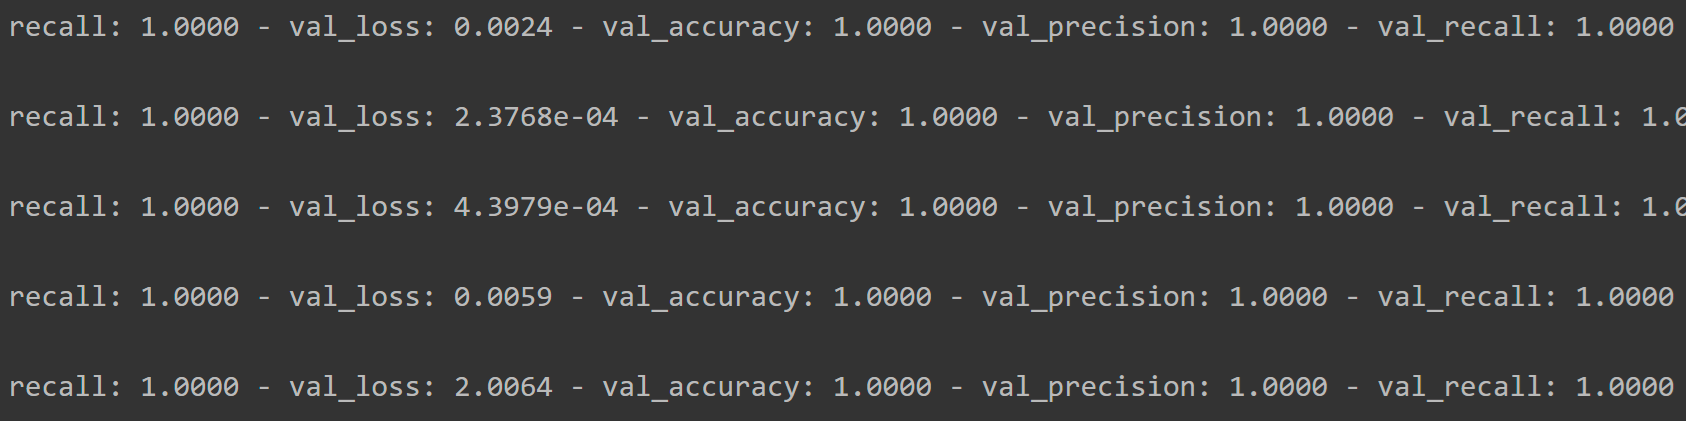

In [ ]:
#프리 트레인된 모델을 가지고 와서 사용해 보기
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Pre-trained ResNet-18 (ResNet50V2 기반)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# 저수준 레이어 프리즈
for layer in base_model.layers:
    layer.trainable = False

# 커스터마이즈된 출력층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # 이진 분류용 출력층

# 최종 모델 생성
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE
)
# 테스트 데이터 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Epoch 1/10
261/261 [==============================] - 88s 259ms/step - loss: 0.1626 - accuracy: 0.9330 - precision: 0.9480 - recall: 0.9627 - val_loss: 0.0938 - val_accuracy: 0.9615 - val_precision: 1.0000 - val_recall: 0.9615

Epoch 2/10
261/261 [==============================] - 54s 208ms/step - loss: 0.0974 - accuracy: 0.9634 - precision: 0.9750 - recall: 0.9759 - val_loss: 0.0595 - val_accuracy: 0.9760 - val_precision: 1.0000 - val_recall: 0.9760


Epoch 9/10
261/261 [==============================] - 61s 233ms/step - loss: 0.0366 - accuracy: 0.9892 - precision: 0.9932 - recall: 0.9923 - val_loss: 0.0279 - val_accuracy: 0.9875 - val_precision: 1.0000 - val_recall: 0.9875

Epoch 10/10
261/261 [==============================] - 63s 243ms/step - loss: 0.0313 - accuracy: 0.9919 - precision: 0.9949 - recall: 0.9942 - val_loss: 0.0088 - val_accuracy: 0.9981 - val_precision: 1.0000 - val_recall: 0.9981

![지표12.png](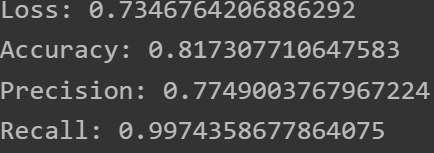)


# 이번 메인 퀘스트에서 베이스 모델과 바뀐 모델에 대한 바꾼 이유에 대한 고찰과 평가
평가의 기준은 베이스 모델과 증강후 학습한 결과 이후
실제 모델 구조 변경후 베이스 모델과의 성능 비교는 마지막에 하게 되어
ResNet-18 모델 구현에 대한 고찰과 평가를 한 뒤에 적겠습니다.
중간에 그래프가 사진이거나 결과 값이 텍스트로 된 건  
코랩용량을 다 써서 lms에서 작동한 것을 첨부하였습니다.

1. 베이스 모델과 증강 이미지를 생성후 베이스 모델과  비교하기
베이스모델
베이스 모델의 경우 정확도는 처음  Epoch1  73.03에서 시작하여 Epoch 10에서 95.5 안정적으로 학습되는 모습을 보여주 안정적이고 재현율과 높은 정밀도로 생각보다 좋은 지표를 보여주 었습니다.
다만 8회 와 10회의 경우 검증 로스가 급격하게 올라간 부분도 있고 손실자체도 많이 크기 때문에 제대로 학습하지 못하거나 과적합의 경우도 있다고 생각합니다.
 특히 이번 resnet모델 구현까지 데이터의 불균형이 모델이 나타내는 좋은 지표가 거꾸로 받아들이기 어려운 가장 큰 포인트로 작용 하지 않았나 싶습니다.
 이러한 불균형에 대한 생각의 이번 모델을 테스트 하면서 계속 가지고 있게 되는 의문점 이였습니다.

증강 생성 후의 모델 학습
노드에서 예시로 들어준 증강 방법으로는 좌우 방향을 전환하여 데이터를 증강 하는 방법 이였습니다. 처음에는 어짜피 엑스레이의 경우 중심부를 맞춰서 찍는 경우가 많고 그렇기 때문에 좌우가 돌아간 사진의 경우는 거의 없다고 생각하여 기울기나 좌우로 사진을 당겨서 테스트 할 부분이 없을 거라는 건 생각해봤습니다.

테스트는 두 가지 방법 처음에는 검증 까지 증강이 된 방식과 되지 않은 방식 두 가지로 하였습니다. 처음 검증까지 같이 된 방식으로 하고 어떤 의미인지 찾다가 알게 된 것은 보통은 검증 데이터 까지 증강이 되면 학습 후 지표에 대한 해석에 문제가 생길 수 있으므로 보통은 하지 않는다는 것을 알게되었습니다.

검증 데이터 까지 증강 한 모델
학습과 검증 데이터에 정밀도와 재현율도 매우 높고 학습 손실 수치도 낮은 부분이 있었지만 테스트에서는 정밀도가 오히려 베이스보다 떨어지느 경우가 있었습니다.
고로 베이스 모델 보다 일반화가 잘 되지 못하였습니다.

검증 데이터 증강 제외 한 모델
테스트데이터에는 비교적 안정적인 수치를 보여주지만 검증 성능에서는 앞에 두 케이스보다 훨씬 불안정한 부분이 있는 것 같습니다. 특히 8~10회 사이에서는 테스트데이터가 더 높은 과적합의 경향도 보이고 이 또한 베이스 모델 보다 못한 경우였습니다.

증강에 대한 고찰
이러한 더 좋지 않은 결과를 보여주는 것을 보아 증강을 하게 되면 모델이 성능이 떨어지는 부분을 찾을 수 있었는데 왜 이런 결과를 나타낼까 생각해 본 건 증강을 하게 될 경우 세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 , 바이러스성 폐렴 (오른쪽)은 양쪽 폐에 서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타납니다.
이 부분에서 그림에서도 볼 수 있듯이 특정 폐렴의 경우 좌측이나 우측에 좀 더 눈에 띄게 표시되는 경향이 있는데 이렇듯 대칭이 아닌 사진을 좌우를 바꾸게 되면 그 결과 우측에 눈에 띄는 건 좌측으로 가서 학습하고 좌측에 눈에 띄는 건 우측으로 가서 학습이 되어 반대의 경우도 학습을 함으로 써 오히려 더 모델 성능이 떨어지지 않았나 생각합니다. 증강을 다른 케이스로 시도해 보지는 못했지만 차라리 좌우 보다는 환자마다 음영과 크기가 다르기 때문에 위치나 사이즈를 조금 바꿔봐도 괜찮지 않을까 생각합니다.



2. ResNet-18모델 구현에 대한 고찰과 평가
사실 이 부분에서 먼저 집고 넘어가야 하는 것은 전반적으로 모든 모델이 Recall 즉 재현율에 대해 너무나도 높다 못해 1.0으로 나왔다는 점입니다. 실제로 위의 증강에 대한 고찰은 이부분을 진행하고 했기 때문에 다양한 증강보다는 좌우 대칭 증강 그리고 드롭 아웃 추가 SGD사용등 다른 하이퍼 파라미터 조정 방식을 사용 했지만  재현율이 너무나도 높게 나왔습니다.
 이 부분에서 드는 생각은 저번 퀘스트 때 구현한 포켓몬 데이터 셋에 대한 거였습니다. 포켓몬 데이터셋 또한 전설의 포켓몬이 매우 적기 때 문에 모든 테스트 지표에 대해 일반 포켓몬이라고 응답할 경우에는 80프로가 넘는 재현율을 보여주는 것 처럼 이데이터셋 또한 데이터의 불균형으로 인해 양성이라고 대답하는 경우 음성보다 훨씬 더 높은 정확도를 가지게 된다는 것을 생각 하게 되었습니다.
 3875/5216 = 0.743 -> 양석으로만 찍어도 74프로 가량 맞음
레즈넷의 경우는 파라미터를 조정 한 부분이 많아 바뀐 부분과 결과 에 대한 생각을 짧게 적겠습니다.
1.검증에 증강이 들어 가지 않은 데이터 셋
데이터가 횟수 별로 정확도가 늘었다 줄었다 함 이는 과적합 혹은 불균형에 기인한 것으로 생각 로스자체는 줄지만  실제 테스트는 베이스보다 낮게 나옴
2.SGD옵티마이저 변경
정확도가 올라가지않고 재현율만 높음 전형적인 불균형 케이스
3.클래스 가중치 비적용(일반 데이터 셋이 적기에 적용했지만 혹시나 싶어 빼봄)
트레인 로스는 매우 조금 줄어들고 테스트 정확도는 훨신더 떨어짐
4.레즈넷 모델에 드롭 아웃추가
드롭아웃+클래스 정밀도 없음
정확도는 매우 향상 되었으나 다른 모델에 비해 검증 로스가 조금 더 높고 정밀도가 낮음
드롭아웃+ 클래스 정밀도 있음
가장 그래도 높은 성능과 안정적인 점차 손실감소 및 성능 상승의 안정적인 지표를 나타내고 있음 지표만 보면은 과적합에 대한 우려도 적을 것으로 봄
드롭아웃+학습데이터 증강
위의 증강과 마찬가지로 좋지 않은 성능을 보여주고 있음

4. 다른 구조의 모델(인셉션 모델)학습 후 베이스 모델과 비교하기
사실 이 부분은resnet모델의 성능이 생각만큼 되지 않기 때문에  다른 모델은 어떨까 생각해보다가 해보게 된 케이스 입니다.
특히 엑스레이에서 폐렴이 나타내는건 그림자같은 음영의 부분이기에 사람마다 그 사이즈나 선명도가 제각각 일 텐데 하나의 커널 사이즈보다는 인셉션 처럼 다양한 사이즈의 커널을 적용해 보면 어떨까 라는 생각으로 적용해 봤습니다.  (레즈넷은 기본모델은 직접 만들어보고 다른 부분은 인터넷의 도움을 받았으나 인셉션 모델의 경우 실제 구조를 아직 잘 이해하지 못하였고 구현 부분에서 전혀 이해하지 못하 였기 때문에 인터넷에 있는 것을 따와서 적용 하였습니다.)
인셉션 모델은 첫 5회에 지표가 좋아서 10회까지로 늘려봤습니다.
실제로 트레인 로스와 정확도 검증 로스와 정확도는 눈에 띄게 우상향 하는결과를 보여주긴 했습니다. 다만 6회쯤 이후 부터는 트레인이 정확도가 높아지는 것을 보아 6회이 후 부터는 과적합에 대한 징후가 보이는 것으로 판단 됩니다.
레즈넷이나 cnn 의경우 시각화를 하게 되면 상당히 불안 정한 그래프를 보여주는 반면 인셉션 모델의 경우는 성능이 점진적으로 증가하는 모습이 상당히 안정적이였습니다.

4. 프리트레인된 resnet-18 모델 사용
프리트레인된 모델을 사용할 경우 코드로 만든 모델보다 얼마나 좋은지 궁금해서 사용해 봤습니다. 검색후 CIFAR10 데이터 세트에는 상호 배타적인 10개 클래스에 속하는 60,000개의 컬러 이미지가 포함되어 있다라는 것을 보고 적용해 보았습니다.
모델은 저차원에서 프리즈하고 학습을 진행 했습니다.
실제로 위에서 모델을 만들어서 테스트 한것보다 정밀도 재현율은 둘다 높고 거기에  손실 또한 매우 안정적으로나와 같은 높은 정확도이지만 과적합에 대한 우려는조금더 적긴 했습니다. 하지만 precision이 1.0인 케이는 극히 드물 기 때문에 데이터셋의 불균형으로 인한 모델의 과적합을 배제 할 수 없으며 하고 나서 들은 생각은 프리트레인된 모델은 컬러 이미지를 학습했다고 나오는데 엑스레이의 사진은 흰색과 검은색 그 사이의 색이 많기 때문에 흑백이미지를 학습한 프리트레인 모델을 가지고 했어도 더 좋지 않았을까 라는 생각을 했습니다.



참조 사이트
레즈넷-18의 구조 https://www.researchgate.net/figure/ResNet-18-Architecture_tbl1_322476121

잔차연결 구현화 예제 코드 본 사이트: https://chaeso-coding.tistory.com/153


사전학습된 레즈넷-18 모델 가져올 때 참고 사이트 https://www.tensorflow.org/tfmodels/vision/image_classification

lms 노드 cnn 요약 http://taewan.kim/post/cnn/

인셉션모